In [1]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from churn_opt.data import load_telco_csv
from churn_opt.features import add_features
from churn_opt.models import build_pipeline
from churn_opt.scenarios import SCENARIOS
from churn_opt.profit import (
    compute_expected_profit_per_customer,
    profit_from_targeting,
    select_score_threshold_by_profit,
)

sns.set_theme()
plt.rcParams["figure.figsize"] = (9, 5)


In [2]:
df = load_telco_csv("../data/raw/Telco-Customer-Churn.csv")
df = add_features(df)

if "TotalCharges" in df.columns:
    df = df.drop(columns=["TotalCharges"])

train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Churn"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.25, stratify=train_df["Churn"], random_state=42)

X_train = train_df.drop(columns=["Churn"])
y_train = train_df["Churn"].values
X_val = val_df.drop(columns=["Churn"])
y_val = val_df["Churn"].values
X_test = test_df.drop(columns=["Churn"])
y_test = test_df["Churn"].values

mc_val = X_val["MonthlyCharges"].to_numpy()
mc_test = X_test["MonthlyCharges"].to_numpy()


In [3]:
pipe = build_pipeline(train_df, model_type="lr", random_state=42)
pipe.fit(X_train, y_train)

p_val = pipe.predict_proba(X_val)[:, 1]
p_test = pipe.predict_proba(X_test)[:, 1]


In [4]:
rows = []

for scen_key, scen in SCENARIOS.items():
    # scores
    score_val = compute_expected_profit_per_customer(p_val, mc_val, scen)
    score_test = compute_expected_profit_per_customer(p_test, mc_test, scen)

    # policies
    call_none = profit_from_targeting(y_test, np.zeros_like(y_test, dtype=bool), mc_test, scen)
    call_all  = profit_from_targeting(y_test, np.ones_like(y_test, dtype=bool),  mc_test, scen)

    # threshold
    best_s, _ = select_score_threshold_by_profit(score_val, y_val, mc_val, scen)
    targeted_thr = (score_test >= best_s)
    profit_thr = profit_from_targeting(y_test, targeted_thr, mc_test, scen)

    # best top-k on TEST
    order = np.argsort(-score_test)
    n = len(score_test)
    ks = np.linspace(0.01, 1.0, 100)

    best_topk_profit = -np.inf
    best_k = None
    for k in ks:
        m = max(1, int(round(n * k)))
        targeted = np.zeros(n, dtype=bool)
        targeted[order[:m]] = True
        prof = profit_from_targeting(y_test, targeted, mc_test, scen)
        if prof > best_topk_profit:
            best_topk_profit = prof
            best_k = k

    rows.append({
        "scenario": scen_key,
        "call_none": call_none,
        "call_all": call_all,
        "score_threshold": profit_thr,
        "best_topk": best_topk_profit,
        "best_k": best_k,
    })

policy_df = pd.DataFrame(rows)
policy_df


,scenario,call_none,call_all,score_threshold,best_topk,best_k
0,worst,0.0,-20125.959,0.000,-62.8475,0.01
1,base,0.0,-4997.088,2445.306,2537.9240,0.21
2,best,0.0,47948.040,49018.944,49248.4860,0.75


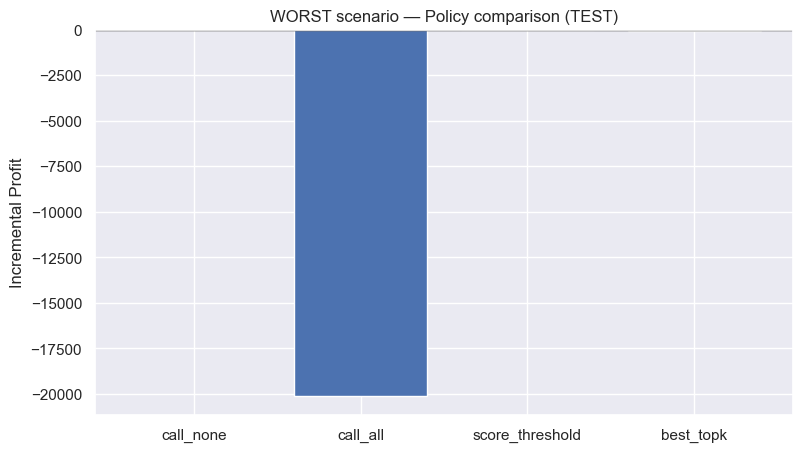

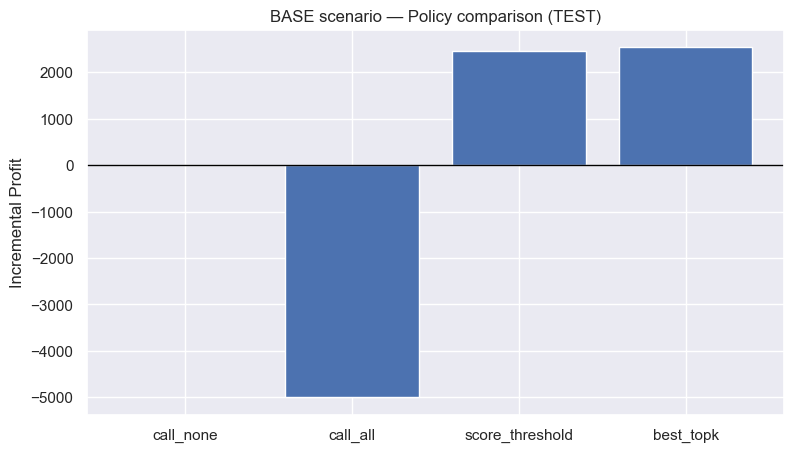

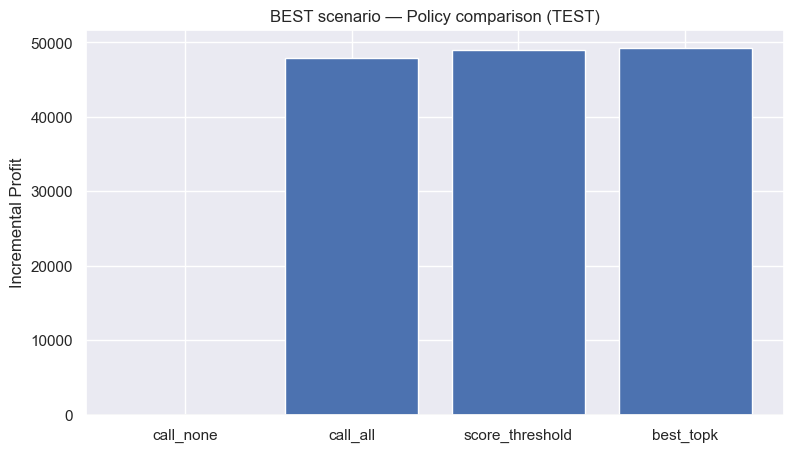

In [5]:
for scen in policy_df["scenario"]:
    row = policy_df[policy_df["scenario"] == scen].iloc[0]

    data = pd.DataFrame({
        "policy": ["call_none", "call_all", "score_threshold", "best_topk"],
        "profit": [row["call_none"], row["call_all"], row["score_threshold"], row["best_topk"]],
    })

    plt.bar(data["policy"], data["profit"])
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"{scen.upper()} scenario — Policy comparison (TEST)")
    plt.ylabel("Incremental Profit")
    plt.show()


In the worst scenario, the rational decision is to not run any campaign at all.

In the base and best scenarios, targeted interventions dominate both extremes.

The score-threshold policy provides a strong balance between selectivity and profitability.

This confirms that decision rules must be optimized jointly with the model, not chosen heuristically.